![user-user](./wallpaper.jpg)

# Memory Based Collaborative Filtering

- https://www.springer.com/gp/book/9783319296579
- https://numpy.org/

In [1]:
import time

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

In [2]:
np.random.seed(10)

![user-user](./wallpaper.jpg)

## Explicit & Implicit Rating

#### Timestamp Matrix

In [3]:
def get_random_timestamp_matrix(shape: tuple, window: int = 100) -> np.array:
    """
    Timestamp Matrix Generator.
    """
    return np.floor(np.random.uniform(low=0, high=window, size=shape[0] * shape[1]).reshape(shape))

In [4]:
print(get_random_timestamp_matrix((5, 10), window=20))

[[15.  0. 12. 14.  9.  4.  3. 15.  3.  1.]
 [13. 19.  0. 10. 16. 12. 14.  5. 18. 14.]
 [10.  2.  7. 13.  8.  8. 12. 10. 13. 12.]
 [16. 10. 18.  6.  1.  6.  2. 16.  0. 12.]
 [10. 16.  3. 17.  7. 15.  5. 17.  6.  3.]]


#### Age Function

[1.         0.9990005  0.998002   0.9970045  0.99600799 0.99501248
 0.99401796 0.99302444 0.99203191 0.99104038 0.99004983 0.98906028
 0.98807171 0.98708414 0.98609754]


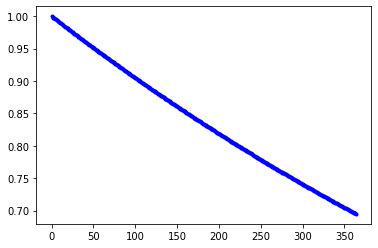

In [5]:
discount: float = 0.001
X: np.array = np.e ** (-discount * np.arange(365))
print(X[:15])
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, '.', color='blue')
plt.show()

In [6]:
def age(X: np.array, ts: np.array, discount: float = 365) -> np.array:
    """
    Age function.
    """
    return X * np.e ** (-discount * ts)

In [7]:
X: np.array = np.array([
    [3, 3, 3],
    [1, np.nan, 0],
    [1, 3, 2]
])
ts: np.array = np.array([
    [1, 2, 3],
    [9, 5, 2],
    [1, 0, 0],
])
print(age(X, ts))

[[9.11245423e-159 2.76789458e-317 0.00000000e+000]
 [0.00000000e+000             nan 0.00000000e+000]
 [3.03748474e-159 3.00000000e+000 2.00000000e+000]]


#### Likes Matrix

In [8]:
def get_random_likes_matrix(shape: tuple, p: int = 0.2, scale: float = 5.) -> np.array:
    """
    Likes Matrix Generator.
    """
    return np.random.binomial(scale, p, shape[0] * shape[1]).reshape(shape).astype(float)

In [9]:
print(get_random_likes_matrix((5, 10), p=0.2))

[[1. 0. 2. 0. 1. 3. 3. 1. 2. 0.]
 [1. 2. 1. 1. 0. 1. 0. 0. 1. 2.]
 [0. 1. 0. 1. 1. 0. 2. 2. 2. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0. 1. 1.]
 [1. 0. 0. 3. 1. 1. 3. 1. 0. 1.]]


#### Shares Matrix

- https://www.geeksforgeeks.org/implement-sigmoid-function-using-numpy/

$$ S(x) = \frac{1}{1 + e^{-x}} $$

[0.09090909 0.21373027 0.42492566 0.66761437 0.84519681 0.93687393
 0.97581204 0.99096358 0.99665659 0.99876742 0.99954621 0.99983301
 0.99993856 0.9999774  0.99999168]


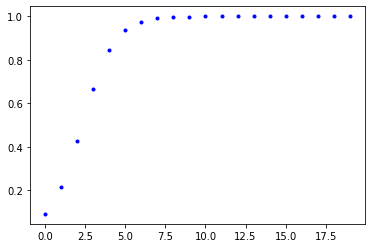

In [10]:
X: np.array = 1 / (1 + 10 * np.e ** (-np.arange(20)))
print(X[:15])
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, '.', color='blue')
plt.show()

[3. 1. 0. 0. 2. 2. 0. 1. 2. 0. 1. 0. 0. 1. 0.]


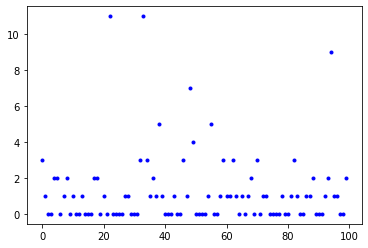

In [11]:
X: np.array = np.floor(np.random.lognormal(0, 1, 100))
print(X[:15])
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, '.', color='blue')
plt.show()

In [12]:
def get_random_shares_matrix(shape: tuple, scale: int = 1) -> np.array:
    """
    Shares Matrix Generator.
    """
    X: np.array = np.floor(np.random.lognormal(0, 1, shape[0] * shape[1]))
    X[X > 0] = scale
    return X
    # return scale / (1 + 10 * np.e ** (-X.reshape(shape)))

In [13]:
print(get_random_shares_matrix((5, 10), scale=5))

[5. 0. 0. 0. 0. 5. 5. 0. 5. 0. 5. 5. 0. 5. 0. 0. 5. 5. 0. 0. 0. 5. 5. 0.
 0. 5. 0. 5. 5. 5. 0. 5. 5. 0. 5. 5. 0. 0. 5. 0. 0. 5. 5. 5. 5. 5. 0. 0.
 0. 5.]


#### Ratings Matrix

The ratings matrix is denoted by `R` and it is an `m` by `n` matrix containing `m` users and `n` items. The rating of user `u1` for item `i3` is denoted by `r13`.

$$ U = \{ u_1, u_2 ... u_m \} \land |U| = m $$

$$ I = \{ i_1, i_2 ... i_n \} \land |I| = n $$

$$ R = \{ r_{1,1}, r_{1,2} ... r_{2,1}, r_{2,2} ... r_{m,n} \} \land |R| = m \times n $$

In [14]:
def get_random_ratings_matrix(shape: tuple, scale: float = 5) -> np.array:
    """
    Random dataset generator.
    """
    ratings: np.array = scale * np.random.randn(*shape)
    ratings[ratings < 0] = np.nan
    ratings[ratings > scale] = scale
    ratings = np.floor(ratings)
    return ratings

In [15]:
ratings: np.array = get_random_ratings_matrix((3, 10), scale=5)
print(ratings)

[[nan  2. nan nan nan nan  3. nan  5.  5.]
 [nan nan nan  2.  0.  5. nan  2. nan nan]
 [ 5.  1.  3. nan nan  0. nan  3.  2. nan]]


#### Cold Start Dimensionality Reduction

In [16]:
def get_active_users(ratings: np.array, min_ratings: int = 10) -> np.array:
    """
    Cold Start users removal.
    """
    return ratings[np.sum(~np.isnan(ratings), axis=1) >= min_ratings]

In [17]:
X: np.array = np.array([
    [1, 1, 1, 2, 3],
    [1, 1, np.nan, 2, 3],
    [np.nan, np.nan, 3, np.nan, 2],
])
Y: np.array = get_active_users(X, 3)
print(Y)

[[ 1.  1.  1.  2.  3.]
 [ 1.  1. nan  2.  3.]]


#### Negative Items Dimensionality Reduction

In [18]:
def get_good_items(ratings: np.array, min_rating: float = 0) -> np.array:
    """
    Bad Items users removal.
    """
    totals: np.array = np.nansum(ratings.T, axis=1)
    count: np.array = np.count_nonzero(~np.isnan(ratings.T), axis=1)
    count[count == 0] = 1
    mask = totals / count > min_rating
    return ratings.T[mask.reshape(ratings.shape[1])].T

In [19]:
X: np.array = np.array([
    [1, 1, 1, 2, 3],
    [1, 1, np.nan, 2, 3],
    [np.nan, np.nan, 3, np.nan, 2],
])
Y: np.array = get_good_items(X, 1.5)
print(Y)

[[ 1.  2.  3.]
 [nan  2.  3.]
 [ 3. nan  2.]]


#### Views Matrix

- https://en.wikipedia.org/wiki/Log-normal_distribution

[ 1.  1.  0.  0.  0.  1.  2.  0.  3.  1.  0.  1.  2.  1. 10.]


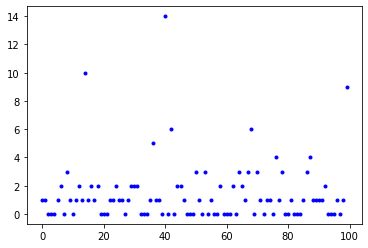

In [20]:
X: np.array = np.floor(np.random.lognormal(0, 1, 100))
print(X[:15])
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, '.', color='blue')
plt.show()

In [21]:
def get_random_views_matrix(shape: tuple) -> np.array:
    """
    Random views matrix generator.
    """
    return np.floor(np.random.lognormal(0, 1, shape[0] * shape[1])).reshape(shape)

In [22]:
views: np.array = get_random_views_matrix((3, 10))
print(views)

[[2. 0. 1. 0. 1. 1. 1. 0. 0. 1.]
 [0. 2. 0. 0. 2. 0. 0. 1. 1. 0.]
 [1. 0. 1. 1. 1. 2. 0. 0. 0. 0.]]


#### Merge Feedback

In [23]:
def get_merged_feedback_matrix(*feedback) -> np.array:
    """
    Merge Feedback Matrix.
    """
    X: np.array = np.vstack([
        f.reshape(f.size)
        for f in feedback
    ])
    n: np.array = np.count_nonzero(~np.isnan(X), axis=0)
    empty: np.array = n == 0
    n[empty] = 1
    Y: np.array = np.nansum(X, axis=0) / n
    Y[empty] = np.nan
    return Y.reshape(feedback[0].shape)

In [24]:
min_rating: float = 0
max_rating: float = 5
stars: np.array = get_random_ratings_matrix((4, 3), scale=max_rating)
empty: np.array = np.isnan(stars)
ts: np.array = get_random_timestamp_matrix(stars.shape, window=20)
stars = age(stars, ts)
views: np.array = get_random_views_matrix(stars.shape)
likes: np.array = get_random_likes_matrix(stars.shape, p=0.2, scale=max_rating)
likes.reshape(likes.size)[views.reshape(views.size) == 0] = np.nan
bookmarked: np.array = get_random_likes_matrix(stars.shape, p=0.5, scale=max_rating)
bookmarked.reshape(bookmarked.size)[views.reshape(views.size) == 0] = np.nan
shares: np.array = get_random_shares_matrix(stars.shape, scale=max_rating)
shares.reshape(likes.size)[views.reshape(views.size) == 0] = np.nan
ts: np.array = get_random_timestamp_matrix(stars.shape, window=20)
shares = age(likes, ts)
user_item: np.array = get_merged_feedback_matrix(stars, shares, likes, bookmarked)
user_item[empty] = np.nan
print(empty)
print(stars)
print(shares)
print(likes)
print(bookmarked)
print(user_item)

[[False  True False]
 [False  True False]
 [False False  True]
 [ True  True  True]]
[[ 0. nan  0.]
 [ 0. nan  2.]
 [ 0.  0. nan]
 [nan nan nan]]
[[ 0.  0. nan]
 [ 0.  0. nan]
 [nan  0.  0.]
 [nan nan  0.]]
[[ 2.  1. nan]
 [ 1.  1. nan]
 [nan  1.  0.]
 [nan nan  0.]]
[[ 3.  2. nan]
 [ 4.  2. nan]
 [nan  2.  1.]
 [nan nan  0.]]
[[1.25  nan 0.  ]
 [1.25  nan 2.  ]
 [0.   0.75  nan]
 [ nan  nan  nan]]


![user-user](./wallpaper.jpg)

## Normalization

- https://en.wikipedia.org/wiki/Normalization_(statistics)

In statistics and applications of statistics, normalization can have a range of meanings. In the simplest cases, normalization of ratings means adjusting values measured on different scales to a notionally common scale, often prior to averaging.

$$ \bar{\mu} = \frac{\sum\limits^{^n}_{i=1} x_i}{n}	 $$

$$ σ^2 = \frac{\sum\limits^{^n}_{i=1} (x_i - \bar{\mu})^2}{n}	 $$

$$ z = \frac{x_i - \bar{\mu}}{σ}	 $$

In [25]:
def normalize(matrix: np.array) -> tuple:
    """
    Normalization Function.
    Returns z-score of each element in the input matrix.
    """    
    sample_size: np.array = np.sum(~np.isnan(matrix), axis=1)
    sample_size[sample_size == 0] = 1
    mean: np.array = np.nansum(matrix, axis=1) / sample_size
    mean = mean.reshape(mean.shape[0], 1)
    variance: np.array = np.nansum(np.power(matrix - mean, 2), axis=1) / sample_size
    variance = variance.reshape(variance.shape[0], 1)
    variance[variance == 0] = 1
    deviation: np.array = np.sqrt(variance)
    normalized: np.array = (matrix - mean) / deviation
    return mean, deviation, normalized


def denormalize(normalized: np.array, mean: np.array, deviation: np.array) -> tuple:
    """
    Denormalization Function.
    """
    return mean + deviation * normalized

ORIGINAL 
 [[ 0.86451847 -0.98668076  2.39251692  2.57550368  5.41225486  4.68103051
   7.69450706  6.97488815  8.46058548  9.24458417]
 [20.2204969  25.29355248 33.98009167 39.32649819 48.90853317 53.08684621
  59.23639566 67.14745541 72.50153413 80.59318923]]
NORMALIZED 
 [[-1.18589173 -1.75362011 -0.71728302 -0.66116438  0.20881447 -0.01543845
   0.90873878  0.68804504  1.14368079  1.38411861]
 [-1.54967151 -1.28593976 -0.83435469 -0.55641232 -0.05827332  0.15894365
   0.47863883  0.88990923  1.16825046  1.58890943]]
DENORMALIZED 
 [[ 0.86451847 -0.98668076  2.39251692  2.57550368  5.41225486  4.68103051
   7.69450706  6.97488815  8.46058548  9.24458417]
 [20.2204969  25.29355248 33.98009167 39.32649819 48.90853317 53.08684621
  59.23639566 67.14745541 72.50153413 80.59318923]]


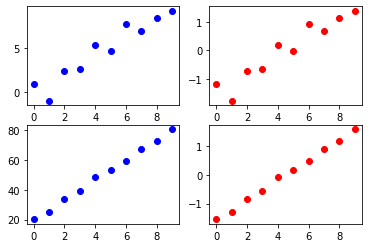

In [26]:
X: np.array = np.vstack([
    np.linspace(0, 10, 10) + np.random.normal(0, 1, 10),
    20 + np.linspace(0, 60, 10) + np.random.normal(0, 1, 10),
])
mean, deviation, Y = normalize(X)
Z = denormalize(Y, mean, deviation)

print('ORIGINAL', "\n", X)
print('NORMALIZED', "\n", Y)
print('DENORMALIZED', "\n", Z)

assert X.shape == Y.shape
assert Z.shape == X.shape
assert (np.floor(X) == np.floor(Z)).all()

grid = np.arange(X.shape[1])
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot(2, 2, 1)
axes.plot(grid, X[0].flat, 'o', color='blue')
axes: Axes = figure.add_subplot(2, 2, 2)
axes.plot(grid, Y[0].flat, 'o', color='red')
axes: Axes = figure.add_subplot(2, 2, 3)
axes.plot(grid, X[1].flat, 'o', color='blue')
axes: Axes = figure.add_subplot(2, 2, 4)
axes.plot(grid, Y[1].flat, 'o', color='red')
plt.show()

## Entropy

- https://en.wikipedia.org/wiki/Entropy_(information_theory)

In information theory, the entropy of a random variable is the average level of "information", "surprise", or "uncertainty" inherent in the variable's possible outcomes.

$$ H(x) = - \sum\limits^{^n}_{i=1} P(x_i) \cdot log P(x_i) $$

In [27]:
def get_entropy_array(matrix: np.array) -> np.array:
    """
    Entropy Matrix.
    """
    P: np.matrix = np.count_nonzero(~np.isnan(matrix.T), axis=1) / matrix.shape[0]
    P[P == 0] = 1
    return np.abs(np.log(P))

In [28]:
X: np.array = np.array([
    [1, np.nan, 3, np.nan, np.nan],
    [4, 5, np.nan, np.nan, np.nan],
    [7, 8, 9, 5, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [1, 2, 2, np.nan, np.nan]
])
E: np.array = get_entropy_array(X)
print(X)
print(E)

[[ 1. nan  3. nan nan]
 [ 4.  5. nan nan nan]
 [ 7.  8.  9.  5. nan]
 [ 7.  8.  9. nan nan]
 [ 7.  8.  9. nan nan]
 [ 7.  8.  9. nan nan]
 [ 7.  8.  9. nan nan]
 [ 1.  2.  2. nan nan]]
[0.         0.13353139 0.13353139 2.07944154 0.        ]


## Cosine Similarity

- https://en.wikipedia.org/wiki/Cosine_similarity

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space. It is defined to equal the cosine of the angle between them, which is also the same as the inner product of the same vectors normalized to both have length 1.

$$ cos(X, Y) = \frac{X \cdot Y}{ \left \Vert X \right \| \cdot \left \Vert Y \right \| } = \frac{ \sum\limits^{^n}_{i=1} X_i \cdot Y_i }{ \sqrt{\sum\limits^{^n}_{i=1} X_i^2} \cdot \sqrt{\sum\limits^{^n}_{i=1} Y_i^2} } $$

$$ ρ_{X,Y} = \frac{ cov(X,Y) }{ σ_X \cdot σ_Y }	 $$

$$ σ^2_X = \frac{\sum\limits^{^n}_{i=1} (x_i - \bar{\mu_X})^2}{n}	 $$

$$ cov(X,Y)^2 = \frac{\sum\limits^{^n}_{i=1} (x_i - \bar{\mu_X})(y_i - \bar{\mu_Y}) }{n}	 $$

In [29]:
def get_cosine(X: np.array, Y: np.array, min_shared_ratings: int = 3) -> float:
    """
    Cosine Similarity function.
    """
    union: np.array = ~np.isnan(np.sum([X, Y], axis=0))
    if np.count_nonzero(union) == 0:
        return 0
    discount: float = min(min_shared_ratings, np.count_nonzero(union)) / min_shared_ratings
    return discount * np.sum(X[union] * Y[union]) / \
        (max(0.0000001, np.sqrt(np.sum(np.power(X[union], 2)))) *\
         max(0.0000001, np.sqrt(np.sum(np.power(Y[union], 2)))))

[ 1. nan  2.  3.  4.  5.  6.  7.  8.  9.] [ 1.  3.  2.  2. nan  8.  9. 10. 11. 12.] 0.9929196160911488


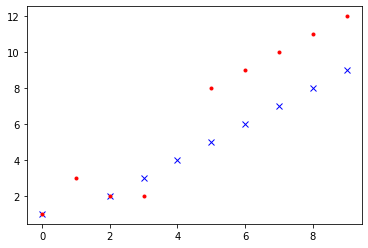

In [30]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 6, 7, 8, 9])
Y: np.array = np.array([1, 3, 2, 2, np.nan, 8, 9, 10, 11, 12])
print(X, Y, get_cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, '.', color='red')
plt.show()

[ 1. nan  2.  3.  4.  5.  6.  7.  8.  9.] [ 10.  30.  20.  20.  nan  80.  90. 100. 110. 120.] 0.9929196160911488


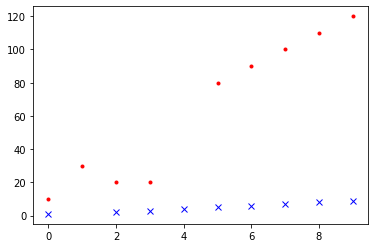

In [31]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 6, 7, 8, 9])
Y: np.array = np.array([10, 30, 20, 20, np.nan, 80, 90, 100, 110, 120])
print(X, Y, get_cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, '.', color='red')
plt.show()

[ 1. nan  2.  3.  4.  5.  7.  9. 10.] [100.  65.  32.  24.  nan  10.   7.   4.   2.] 0.21975098781417202


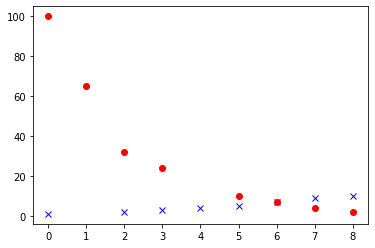

In [32]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 7, 9, 10])
Y: np.array = np.array([100, 65, 32, 24, np.nan, 10, 7, 4, 2])
print(X, Y, get_cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, 'o', color='red')
plt.show()

## Similarity Matrix

In [33]:
def get_similarity_matrix(X: np.array, min_shared_ratings: int = 3, sample: float = 1.) -> np.array:
    """
    Get similarity matrix out of a given matrix.
    """
    Y: np.array = np.zeros((X.shape[0], X.shape[0]))
    P: np.array = np.random.uniform(size=Y.size).reshape(Y.shape) < sample
    for i in range(X.shape[0]):
        for j in range(i + 1, X.shape[0]):
            if P[i][j]:
                Y[i][j] = get_cosine(X[i], X[j], min_shared_ratings=min_shared_ratings)
    return Y + Y.T

In [34]:
X: np.array = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])
S: np.array = get_similarity_matrix(X, sample=0.8)
print(X)
print(S)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[0.         0.97463185 0.        ]
 [0.97463185 0.         0.99819089]
 [0.         0.99819089 0.        ]]


## Top K-Similar Rows

- https://en.wikipedia.org/wiki/Adjacency_matrix
- https://numpy.org/doc/stable/reference/generated/numpy.argsort.html

In graph theory and computer science, an adjacency matrix is a square matrix used to represent a finite graph. The elements of the matrix indicate whether pairs of vertices are adjacent or not in the graph.

In [35]:
def get_adjacency_matrix(similar: np.array, top: int = 4) -> np.array:
    """
    Get top k similar rows of a similarity matrix.
    """
    closest: np.array = np.argsort(similar)
    return closest[:, closest.shape[1] - top:]

In [36]:
X: np.array = np.array([
    [0, 2, 3, 1],
    [8, 0, 6, 1],
    [7, 6, 0, 2],
    [2, 3, 1, 0]
])
S: np.array = get_adjacency_matrix(X, 2)
print(X)
print(S)

[[0 2 3 1]
 [8 0 6 1]
 [7 6 0 2]
 [2 3 1 0]]
[[1 2]
 [2 0]
 [1 0]
 [0 1]]


## Collaborative Filtering

Filling the collaborative filtering matrix with ratings from similar rows. The predicted value is the weighted sum of the adjacent rows. Values are denormalized so that the approximate user scores. Entropy is applied to promote novelty across recommendations.

$$ \hat{R_{i,j}} = \mu + σ \cdot \frac{ \sum\limits^{^n}_{u=1} w_u \cdot R_{u,j} }{ \sum\limits^{^n}_{u=1} w_u } $$

$$ E = \{ (r_{1,1} - \hat{r_{1,1}}), (r_{1,2} - \hat{r_{1,2}}), ..., (r_{i,j} - \hat{r_{i,j}}) \} $$

In [37]:
def get_predictions_matrix(ratings: np.array, normalized: np.array, entropy: np.array, adjacent: np.array, similarity: np.array) -> np.array:
    """
    Collaborative Filtering function.
    """
    predictions: np.array = np.empty(ratings.shape)
    for i in range(normalized.shape[0]):
        for j in range(normalized.shape[1]):
            predictions[i, j] = np.nan
            total: float = 0
            weights: float = 0
            y: float = ratings[i][j]
            for k in adjacent[i]:
                if np.isnan(normalized[k][j]):
                    continue
                weight: float = similarity[i][k] * entropy[k]
                weights += weight
                total += normalized[k][j] * weight
            if weights > 0:
                y: float = total / weights
            predictions[i, j] = y
    return predictions

In [38]:
def get_recommendations_matrix(ratings: np.array, predictions: np.array) -> np.array:
    """
    Collaborative Filtering function.
    """
    r = np.isnan(ratings).reshape(ratings.size)
    t = np.copy(predictions.reshape(predictions.size))
    t[~r] = np.nan
    return t.reshape(predictions.shape)

In [39]:
X: np.array = np.array([
    [1., np. nan],
    [np.nan, 1.],
])
Y: np.array = np.array([
    [2., 0.],
    [0., 2.]
])
Z: np.array = get_recommendations_matrix(X ,Y)
print(Z)

[[nan  0.]
 [ 0. nan]]


## Evaluation

$$ E = \{ (r_{1,1} - \hat{r_{1,1}}), (r_{1,2} - \hat{r_{1,2}}), ..., (r_{i,j} - \hat{r_{i,j}}) \} $$

$$ RMSE = \sqrt{ \frac{ \sum\limits^{^n}_{e=1} e_i^2 }{|E|}} $$

$$ NRMSE = \frac{ RMSE }{ (r_{max} - r_{min}) } $$

In [40]:
def get_nrmse(ratings: np.array, predictions: np.array) -> np.matrix:
    """
    Evaluation Function.
    """
    predicted: np.array = predictions.reshape(predictions.size)
    target: np.array = ratings.reshape(ratings.size)
    tests: np.array = ~np.isnan(target)
    predicted = predicted[tests]
    target = target[tests]
    error: float = np.nansum(np.power((predicted - target), 2))
    trials: int = np.count_nonzero(tests)
    return np.sqrt(error / trials) / (np.nanmax(predicted) - np.nanmin(predicted))

In [41]:
X: np.array = np.array([
    [3, np.nan, 1, np.nan],
    [np.nan, 4, 1, np.nan],
    [np.nan, np.nan, np.nan, np.nan]
])
Y: np.array = np.array([
    [2, 0, 1, np.nan],
    [0, 4, 1, np.nan],
    [np.nan, np.nan, np.nan, np.nan]
])
nrmse: float = get_nrmse(X, Y)
print(nrmse)

0.16666666666666666


## Novelty

- http://ir.ii.uam.es/saul/pubs/fdia11-vargas.pdf

In case we consider an item in a recommendation list, the probability of been discovered, i.e. p(seen|i, R), can be simplified by a decreasing discount function disc. Novelty of an item as the probability of not having been seen. In case we were interested in emphasize highly novel items, a discount rate `d` is applied on `t` times seen.

$$ \hat{R_{u,i}} = R_{u,i} \cdot P(seen/u,i) $$

$$ P(seen/u,i) = \frac{1}{(1 + d)^t} $$

[1.         0.99009901 0.98029605 0.97059015 0.96098034 0.95146569
 0.94204524 0.93271805 0.92348322 0.91433982 0.90528695 0.89632372
 0.88744923 0.8786626  0.86996297]


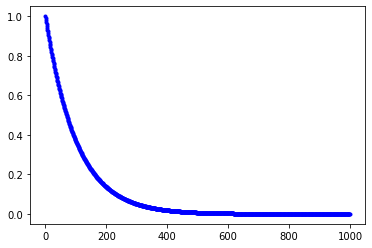

In [42]:
discount: float = 0.01
X: np.array = 1 / (1 + discount) ** np.arange(1000)
print(X[:15])
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, '.', color='blue')
plt.show()

In [43]:
def get_novelty_matrix(recommendations: np.array, views: np.array, discount_rate: float = 0.01) -> np.array:
    """
    Apply novelty to recommendations.
    """
    return recommendations / (1 + discount_rate) ** views

In [44]:
X: np.array = np.array([
    [3, 5, 8],
    [2, 2, 2],
    [1, 0, 5],
])
V: np.array = np.array([
    [5, 0, 100],
    [0, 10, 20],
    [1, 0, 100],
])
Y:np.array = get_novelty_matrix(X, V)
print(Y)

[[2.85439706 5.         2.9576897 ]
 [2.         1.81057391 1.63908894]
 [0.99009901 0.         1.84855606]]


## Top K Recommendations Getter

In [45]:
def get_top_recommendations(recommendations: np.array, top: int = 3) -> np.array:
    """
    Top K recommendations getter.
    """
    X: np.array = np.copy(recommendations)
    X[np.isnan(X)] = 0
    return np.argsort(X)[:,::-1][:,:top]

In [46]:
X: np.array = np.array([
    [1, 2, 3, 4, 8, 3, 2, 2],
    [4, np.nan, 2, 1, 4, 3, 2, np.nan],
])
Y: np.array = get_top_recommendations(X, 3)
print(Y)

[[4 3 5]
 [4 0 5]]


## Recommendation Lists

In [47]:
def get_liked_matrix(top: np.array, adjacent: np.array, ratings: np.matrix, min_rating: float, silent: bool = True) -> np.array:
    """
    Explain Recommendations.
    """
    Z: np.array = np.empty(top.shape).astype(int)
    for user in range(top.shape[0]):
        for j in range(top.shape[1]):
            item = top[user][j]
            X: np.array = ratings[user][adjacent[item]]
            Y: np.array = np.greater(X, min_rating)
            if np.count_nonzero(~Y) == adjacent.shape[1]:
                Z[user][j] = -1
                continue
            Z[user][j] = adjacent[item][Y][np.nanargmax(X[Y])]
            if not silent:
                print(f'Item #{top[user][j]} recommended to User #{user} because they liked Item #{Z[user][j]}.')
    return Z

In [48]:
top: np.array = np.array([
    [0, 1],
    [1, 2],
    [0, 1],
    [0, 2]
])
adjacent: np.array = np.array([
    [1, 2],
    [0, 2],
    [0, 1],
])
user_item: np.array = np.array([
    [np.nan, np.nan, 3],
    [4, 5, np.nan],
    [4, np.nan, 2],
    [0, 0, 1],
])
liked: np.array = get_liked_matrix(top, adjacent, user_item, 3, silent=False)
print(liked)

Item #1 recommended to User #1 because they liked Item #0.
Item #2 recommended to User #1 because they liked Item #1.
Item #1 recommended to User #2 because they liked Item #0.
[[-1 -1]
 [ 0  1]
 [-1  0]
 [-1 -1]]


## Diversity

Diversity is a property of a recommendation list or a set of them composed by one or several recommender systems. It reflects how dissimilar items are to each other in the list. To measure diversity inside a list, researchers often calculate an average pairwise dissimilarity of items in a recommendation list.

## Serendipity

- https://link.springer.com/content/pdf/10.1007/s00607-018-0687-5.pdf

The dictionary definition of serendipity is “the faculty of making fortunate discoveries by accident”.

## Trending Items

In [49]:
def get_trending_items(recommendations: np.array, top: int = 5) -> np.array:
    """
    Trending Items getter.
    """
    trends: np.array = np.nansum(recommendations, axis=1)
    n = np.count_nonzero(~np.isnan(recommendations), axis=1)
    n[n == 0] = 1
    trends /= n
    return np.argsort(trends)[::-1][:top]

In [50]:
X: np.array = np.array([
    [np.nan, 1, 2, 3, np.nan],
    [4, 0, 0, 2, np.nan],
    [np.nan, 3, 3, 5, np.nan],
    [np.nan, np.nan, np.nan, np.nan, np.nan],
])
Y: np.array = get_trending_items(X, 2)
print(Y)

[2 0]


![user-user](./wallpaper.jpg)

## User-Based Collaborative Filtering

In [51]:
# Parameters
USERS: int = 10
ITEMS: int = 15
MAX_RATING: float = 5
TIME_WINDOW: int = 20
LIKE_RATE: float = 0.5
BOOKMARK_RATE: float = 0.5
MIN_ITEM_RATING: float = 1
MIN_USER_RATINGS: int = 2
SIMILARITY_SAMPLE_SIZE: float = 0.4
MIN_SIMILARITY_RATINGS: int = 2

# Explicit & Implicit Rating.
stars: np.array = get_random_ratings_matrix((USERS, ITEMS), scale=MAX_RATING)
empty: np.array = np.isnan(stars)
ts: np.array = get_random_timestamp_matrix(stars.shape, window=TIME_WINDOW)
stars = age(stars, ts)
views: np.array = get_random_views_matrix(stars.shape)
likes: np.array = get_random_likes_matrix(stars.shape, p=LIKE_RATE, scale=MAX_RATING)
bookmarked: np.array = get_random_likes_matrix(stars.shape, p=BOOKMARK_RATE, scale=MAX_RATING)
shares: np.array = get_random_shares_matrix(stars.shape, scale=max_rating)
ts: np.array = get_random_timestamp_matrix(stars.shape, window=TIME_WINDOW)
shares = age(likes, ts)
user_item: np.array = get_merged_feedback_matrix(stars, shares, likes, bookmarked)
user_item[empty] = np.nan

# Recommendation System.
start: float = time.time()   
user_item = get_active_users(user_item, min_ratings=MIN_USER_RATINGS)
user_item = get_good_items(user_item, min_rating=MIN_ITEM_RATING)
mean, deviation, normalized = normalize(user_item)
user_user: np.array = get_similarity_matrix(normalized,
                                            min_shared_ratings=MIN_SIMILARITY_RATINGS,
                                            sample=SIMILARITY_SAMPLE_SIZE)
adjacent: np.array = get_adjacency_matrix(user_user)
entropy: np.array = get_entropy_array(user_item.T)
views: np.array = get_random_views_matrix(user_item.shape)
predictions: np.array = get_predictions_matrix(ratings=user_item,
                                               normalized=normalized,
                                               similarity=user_user,
                                               entropy=entropy,
                                               adjacent=adjacent)
predictions = denormalize(predictions, mean, deviation)
recommendations: np.array = get_recommendations_matrix(user_item, predictions)
recommendations: np.matrix = get_novelty_matrix(recommendations, views)
top: np.array = get_top_recommendations(recommendations.T)

# Model Evaluation.
nrmse: float = get_nrmse(user_item, predictions)

# Reporting
print('USERS', ratings.shape[0])
print('ITEMS', ratings.shape[1])
print('NRMSE', nrmse)
print('ELAPSED', time.time() - start)
print('RECOMMENDATIONS', top.shape)

USERS 3
ITEMS 10
NRMSE 0.26650474731928375
ELAPSED 0.006496429443359375
RECOMMENDATIONS (14, 3)


## Item-Based Collaborative Filtering

In [52]:
# Parameters
USERS: int = 10
ITEMS: int = 15
MAX_RATING: float = 5
TIME_WINDOW: int = 20
LIKE_RATE: float = 0.5
BOOKMARK_RATE: float = 0.5
MIN_ITEM_RATING: float = 1
MIN_USER_RATINGS: int = 1
SIMILARITY_SAMPLE_SIZE: float = 1
TRENDING_ITEMS: int = 5
MIN_LIKE_RATING: int = 1

# Explicit & Implicit Rating.
stars: np.array = get_random_ratings_matrix((USERS, ITEMS), scale=MAX_RATING)
empty: np.array = np.isnan(stars)
ts: np.array = get_random_timestamp_matrix(stars.shape, window=TIME_WINDOW)
stars = age(stars, ts)
views: np.array = get_random_views_matrix(stars.shape)
likes: np.array = get_random_likes_matrix(stars.shape, p=LIKE_RATE, scale=MAX_RATING)
bookmarked: np.array = get_random_likes_matrix(stars.shape, p=BOOKMARK_RATE, scale=MAX_RATING)
shares: np.array = get_random_shares_matrix(stars.shape, scale=max_rating)
ts: np.array = get_random_timestamp_matrix(stars.shape, window=TIME_WINDOW)
shares = age(likes, ts)
user_item: np.array = get_merged_feedback_matrix(stars, shares, likes, bookmarked)
user_item[empty] = np.nan

# Recommendation System.
start: float = time.time()   
user_item = get_active_users(user_item, min_ratings=MIN_USER_RATINGS)
user_item = get_good_items(user_item, min_rating=MIN_ITEM_RATING)
item_user: np.array = user_item.T
views: np.array = get_random_views_matrix(item_user.shape)
mean, deviation, normalized = normalize(item_user)
item_item: np.array = get_similarity_matrix(normalized,
                                            min_shared_ratings=MIN_SIMILARITY_RATINGS,
                                            sample=SIMILARITY_SAMPLE_SIZE)
adjacent: np.array = get_adjacency_matrix(item_item)
entropy: np.array = get_entropy_array(item_user.T)
predictions: np.array = get_predictions_matrix(ratings=item_user,
                                               normalized=normalized,
                                               similarity=item_item,
                                               entropy=entropy,
                                               adjacent=adjacent)
predictions = denormalize(predictions, mean, deviation)
recommendations: np.array = get_recommendations_matrix(item_user, predictions)
recommendations: np.matrix = get_novelty_matrix(recommendations, views)
top: np.array = get_top_recommendations(recommendations.T)
trending: np.array = get_trending_items(recommendations, TRENDING_ITEMS)
liked: np.array = get_liked_matrix(top, adjacent, user_item, min_rating=MIN_LIKE_RATING)

# Model Evaluation.
nrmse: float = get_nrmse(item_user, predictions)

# Reporting
print('USERS', user_item.shape[0])
print('ITEMS', user_item.shape[1])
print('NRMSE', nrmse)
print('ELAPSED', time.time() - start)
print('RECOMMENDATIONS', top.shape)
print('BECAUSE YOU WATCHED', liked.shape)
print('TRENDING', trending.shape)

USERS 10
ITEMS 13
NRMSE 0.09300850664439644
ELAPSED 0.01964402198791504
RECOMMENDATIONS (10, 3)
BECAUSE YOU WATCHED (10, 3)
TRENDING (5,)
